# กำหนดการณ์เชิงเส้นตรง

## 1


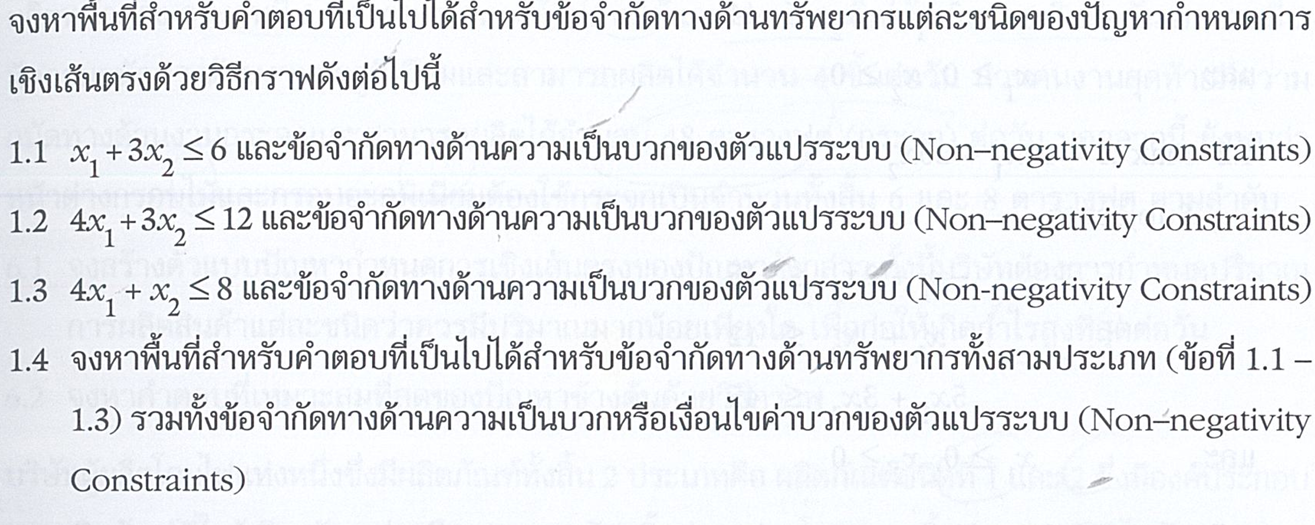

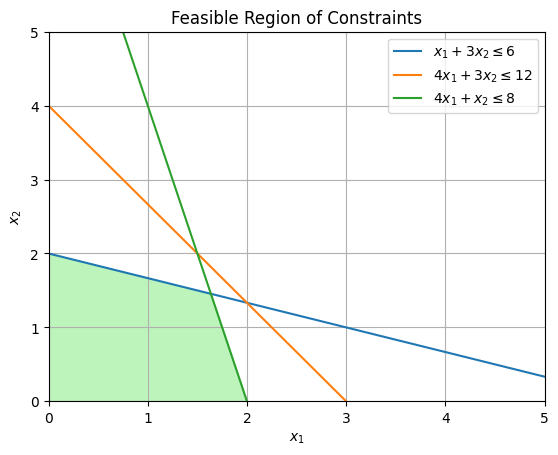

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# สร้างค่าของ x1
x1 = np.linspace(0, 5, 400)

# คำนวณค่า x2 จากสมการ
x2_1 = (6 - x1) / 3
x2_2 = (12 - 4*x1) / 3
x2_3 = 8 - 4*x1

# วาดเส้น boundary ของ constraints
plt.plot(x1, x2_1, label=r"$x_1 + 3x_2 \leq 6$")
plt.plot(x1, x2_2, label=r"$4x_1 + 3x_2 \leq 12$")
plt.plot(x1, x2_3, label=r"$4x_1 + x_2 \leq 8$")

# ระบายพื้นที่ feasible region
x2_feasible = np.minimum.reduce([x2_1, x2_2, x2_3])
x2_feasible = np.maximum(x2_feasible, 0)
plt.fill_between(x1, 0, x2_feasible, where=(x2_feasible>=0), color='lightgreen', alpha=0.6)

# จัดรูปกราฟ
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.grid(True)
plt.title("Feasible Region of Constraints")
plt.show()


## 2

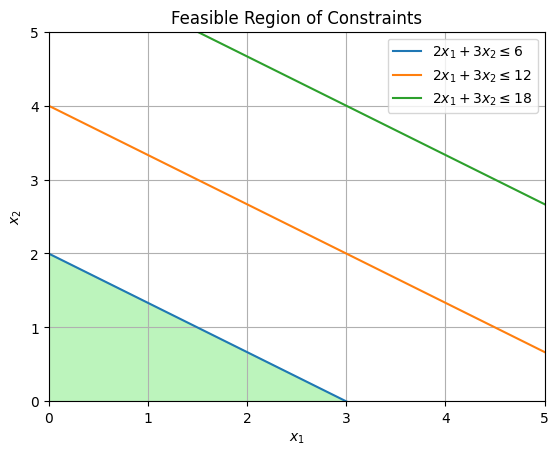

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# สร้างค่าของ x1
x1 = np.linspace(0, 5, 400)

# คำนวณค่า x2 จากสมการ
x2_1 = (6 - 2*x1) / 3
x2_2 = (12 - 2*x1) / 3
x2_3 = (18 - 2*x1) / 3

# วาดเส้น boundary ของ constraints
plt.plot(x1, x2_1, label=r"$2x_1 + 3x_2 \leq 6$")
plt.plot(x1, x2_2, label=r"$2x_1 + 3x_2 \leq 12$")
plt.plot(x1, x2_3, label=r"$2x_1 + 3x_2 \leq 18$")

# ระบายพื้นที่ feasible region
x2_feasible = np.minimum.reduce([x2_1, x2_2, x2_3])
x2_feasible = np.maximum(x2_feasible, 0)
plt.fill_between(x1, 0, x2_feasible, where=(x2_feasible>=0), color='lightgreen', alpha=0.6)

# จัดรูปกราฟ
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.grid(True)
plt.title("Feasible Region of Constraints")
plt.show()


## 5

### code

In [5]:

from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)

class SimplexResult:
    def __init__(self, status: str, objective: float, solution: Dict[str, float], iterations: int, steps: List[str]):
        self.status = status              # 'optimal', 'unbounded', 'infeasible'
        self.objective = objective        # optimal objective (if any)
        self.solution = solution          # variable -> value at termination
        self.iterations = iterations      # number of pivots performed
        self.steps = steps                # textual log of steps

def _format_df(tableau: np.ndarray, row_names: List[str], col_names: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(tableau, columns=col_names, index=row_names)
    # round for readability
    return df.round(6)

class TwoPhaseSimplex:
    def __init__(self, sense: str, c: List[float], A: List[List[float]], b: List[float], cons: List[str], tol: float=1e-9, bland: bool=True):
        """
        sense: 'max' or 'min'
        c: objective coefficients (length n)
        A: constraint matrix (m x n)
        b: RHS (length m)
        cons: constraint sense for each row: '<=', '>=', or '='
        tol: tolerance for numerical comparisons
        bland: use Bland's rule to avoid cycling (tie-breaking by lowest-index variable)
        """
        self.sense = sense.lower()
        assert self.sense in ('max', 'min')
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.cons = cons
        self.tol = float(tol)
        self.bland = bland

        m, n = self.A.shape
        assert len(self.c) == n, "c and A have incompatible sizes"
        assert len(self.b) == m and len(self.cons) == m, "b/cons length must match number of constraints"

        # If minimization, convert to maximization by negating c.
        self.orig_c = self.c.copy()
        if self.sense == 'min':
            self.c = -self.c
            self.sense = 'max'  # internal: always treat as maximization

        # Normalize constraints so that b >= 0 by multiplying by -1 if needed
        self.An = self.A.copy()
        self.bn = self.b.copy()
        self.cons_norm = list(self.cons)
        for i in range(m):
            if self.bn[i] < -self.tol:
                # multiply row by -1 and flip sense
                self.An[i, :] *= -1
                self.bn[i] *= -1
                if self.cons_norm[i] == '<=':
                    self.cons_norm[i] = '>='
                elif self.cons_norm[i] == '>=':
                    self.cons_norm[i] = '<='
                # '=' stays '='

        self.m = m
        self.n = n

        # Build full column structure: [x vars] + [slacks/surplus] + [artificials]
        self.var_names: List[str] = [f"x{j+1}" for j in range(n)]
        self.slack_idx = []
        self.surplus_idx = []
        self.artificial_idx = []
        self.basic_vars = [-1]*m     # column index of basic variable in each row

        cols = []
        # start with original variables
        cols.extend([self.An[:, j] for j in range(n)])

        # Add slack/surplus/artificials per row
        for i in range(m):
            sense = self.cons_norm[i]
            col_slack = np.zeros(m)
            col_surplus = np.zeros(m)
            col_art = np.zeros(m)
            if sense == '<=':
                # add slack +1
                col_slack[i] = 1.0
                self.slack_idx.append(len(self.var_names))
                self.var_names.append(f"s{i+1}")
                cols.append(col_slack)
                # slack is initial basic var
                self.basic_vars[i] = self.var_names.index(f"s{i+1}")
            elif sense == '>=':
                # add surplus -1 and artificial +1
                col_surplus[i] = -1.0
                self.surplus_idx.append(len(self.var_names))
                self.var_names.append(f"t{i+1}")
                cols.append(col_surplus)
                col_art[i] = 1.0
                self.artificial_idx.append(len(self.var_names))
                self.var_names.append(f"a{i+1}")
                cols.append(col_art)
                # artificial is initial basic var
                self.basic_vars[i] = self.var_names.index(f"a{i+1}")
            elif sense == '=':
                # artificial +1
                col_art[i] = 1.0
                self.artificial_idx.append(len(self.var_names))
                self.var_names.append(f"a{i+1}")
                cols.append(col_art)
                # artificial is initial basic var
                self.basic_vars[i] = self.var_names.index(f"a{i+1}")
            else:
                raise ValueError("Constraint sense must be one of '<=', '>=', '='")

        self.A_full = np.column_stack(cols)  # shape m x total_vars
        self.total_vars = self.A_full.shape[1]

        # Vector of costs for original objective across all current variables (x, slack/surplus 0, artificial 0)
        self.c_full = np.zeros(self.total_vars)
        self.c_full[:self.n] = self.c  # only original x have cost

        # Phase I costs: 0 for non-artificial, -1 for artificial (maximize -sum(a))
        self.c_phase1 = np.zeros(self.total_vars)
        for idx in self.artificial_idx:
            self.c_phase1[idx] = -1.0

        # Build initial tableau for Phase I as [A | b] with last row Cj - Zj
        self.tableau = np.zeros((self.m + 1, self.total_vars + 1))
        self.tableau[:self.m, :self.total_vars] = self.A_full
        self.tableau[:self.m, -1] = self.bn

        # Build Phase I objective row: C - Z with basic = artificials where present
        # Start with C = c_phase1
        self.tableau[-1, :self.total_vars] = self.c_phase1.copy()
        self.tableau[-1, -1] = 0.0
        # Subtract sum(c_B * row) to form C - Z (note: c_B for slack-only rows is 0)
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol in self.artificial_idx:
                c_Bi = self.c_phase1[bcol]  # = -1
                # C - Z := C - c_Bi * row_i
                # Since c_Bi = -1, this is C - (-1)*row = C + row
                self.tableau[-1, :] -= c_Bi * self.tableau[i, :]

        self.steps = []  # log strings
        self.iterations = 0

    def _current_objective_value(self, row: Optional[np.ndarray]=None) -> float:
        if row is None:
            row = self.tableau[-1, :]
        # C - Z tableau stores RHS at bottom as -Z (because RHS: 0 - c_B^T b = -Z)
        return -row[-1]

    def _choose_entering(self, phase: int) -> Optional[int]:
        # Choose entering column: largest positive (C - Z) coefficient
        obj_row = self.tableau[-1, :-1]
        candidates = np.where(obj_row > self.tol)[0]
        if candidates.size == 0:
            return None
        if self.bland:
            return int(candidates.min())
        # Otherwise pick argmax
        return int(candidates[np.argmax(obj_row[candidates])])

    def _choose_leaving(self, enter_col: int) -> Optional[int]:
        col = self.tableau[:self.m, enter_col]
        rhs = self.tableau[:self.m, -1]
        mask = col > self.tol
        if not mask.any():
            return None  # unbounded
        ratios = np.where(mask, rhs / col, np.inf)
        # Tie-break with Bland: pick smallest row index among min ratios
        min_val = ratios[mask].min()
        candidate_rows = np.where(np.isclose(ratios, min_val, atol=1e-12))[0]
        return int(candidate_rows.min())

    def _pivot(self, row: int, col: int):
        """
        Performs a pivot operation on the tableau.
        The pivot is at the intersection of `row` and `col`.
        """
        pivot_element = self.tableau[row, col]
        # Log the row operation for the pivot row
        self.steps.append(
            f"   Row R{row+1} divided by pivot element {pivot_element:.6f} to make it 1."
        )
        self.tableau[row, :] = self.tableau[row, :] / pivot_element

        # Eliminate other row entries
        for r in range(self.m + 1):
            if r == row:
                continue
            factor = self.tableau[r, col]
            if abs(factor) > self.tol:
                # Log the row operation for non-pivot rows
                self.steps.append(
                    f"   Row R{r+1} updated: R{r+1} - ({factor:.6f}) * R{row+1}"
                )
                self.tableau[r, :] -= factor * self.tableau[row, :]

        # Update the basic variable for the pivoted row
        self.basic_vars[row] = col

    def _log_tableau(self, title: str):
        row_names = [self.var_names[self.basic_vars[i]] if self.basic_vars[i] >= 0 else f"row{i+1}" for i in range(self.m)] + ["C - Z"]
        col_names = self.var_names + ["RHS"]
        df = _format_df(self.tableau, row_names, col_names)
        # Store a tuple: (title, DataFrame)
        self.steps.append((title, df))


    def _phase(self, phase_num: int, cvec: np.ndarray) -> Tuple[str, float]:
        self.steps.append(f"--- Starting Phase {phase_num} ---")
        
        # Reset bottom row to C - Z for the given cost vector cvec.
        self.tableau[-1, :] = 0.0
        self.tableau[-1, :self.total_vars] = cvec.copy()
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol >= 0:
                self.tableau[-1, :] -= cvec[bcol] * self.tableau[i, :]

        self._log_tableau(f"Phase {phase_num} — Initial C - Z row")

        while True:
            enter = self._choose_entering(phase_num)
            if enter is None:
                # Optimal for this phase
                z = self._current_objective_value()
                self.steps.append(f"Phase {phase_num} — All Cj-Zj are non-positive. Optimal solution for this phase found.")
                self._log_tableau(f"Phase {phase_num} — Optimal (no positive C-Z). Objective = {z:.6f}")
                return ("optimal", z)

            self.steps.append(f"Entering variable is {self.var_names[enter]} (largest positive Cj-Zj).")

            leave = self._choose_leaving(enter)
            if leave is None:
                self.steps.append(f"All coefficients in the entering column ({self.var_names[enter]}) are non-positive. The solution is unbounded.")
                self._log_tableau(f"Phase {phase_num} — Unbounded in entering {self.var_names[enter]}")
                return ("unbounded", np.inf)

            self.steps.append(f"Leaving variable is {self.var_names[self.basic_vars[leave]]} (smallest ratio).")

            self.iterations += 1
            self.steps.append(f"Iteration {self.iterations} (Phase {phase_num}): Pivot on R{leave+1}, C{enter+1}.")
            self._pivot(leave, enter)
            self._log_tableau(f"After pivot #{self.iterations}")

    def solve(self, show_steps: bool=True) -> SimplexResult:
        # Phase I (only if there are artificials)
        if len(self.artificial_idx) > 0:
            status1, z1 = self._phase(1, self.c_phase1)
            if status1 != "optimal" or z1 < -self.tol:
                # If unbounded in phase I or objective < 0 (shouldn't happen with -sum(a)), report infeasible
                return SimplexResult("infeasible", float("nan"), {}, self.iterations, self.steps)
            # Check feasibility: z1 should be 0 (within tol)
            if abs(z1) > 1e-7:
                self.steps.append(f"Phase 1 objective is {z1:.6f} > 0 → Infeasible.")
                return SimplexResult("infeasible", float("nan"), {}, self.iterations, self.steps)

            # Remove artificial columns; but first try to pivot out any artificial still basic
            for i in range(self.m):
                bcol = self.basic_vars[i]
                if bcol in self.artificial_idx:
                    # Try to pivot to a non-artificial column with non-zero coeff
                    for j in range(self.total_vars):
                        if j in self.artificial_idx:
                            continue
                        if abs(self.tableau[i, j]) > self.tol:
                            self._pivot(i, j)
                            break
                    else:
                        # Entire row may be redundant (zero row with RHS 0). Keep but it's okay to proceed.
                        pass

            # Now drop artificial columns from tableau & names
            keep_cols = [j for j in range(self.total_vars) if j not in self.artificial_idx]
            # Rebuild structures
            self.A_full = self.A_full[:, keep_cols]
            self.var_names = [self.var_names[j] for j in keep_cols]
            self.total_vars = len(keep_cols)
            self.c_full = np.zeros(self.total_vars)
            self.c_full[:self.n] = self.c[:self.n]  # original costs for x vars
            # Slice tableau
            self.tableau = np.column_stack([self.tableau[:, keep_cols], self.tableau[:, -1]])
            # Update basic var indices to new column indexing
            old_to_new = {old: new for new, old in enumerate(keep_cols)}
            for i in range(self.m):
                if self.basic_vars[i] in old_to_new:
                    self.basic_vars[i] = old_to_new[self.basic_vars[i]]
                else:
                    # If a basic var got removed (shouldn't after pivoting), mark as -1
                    self.basic_vars[i] = -1

        # Phase II (optimize original objective)
        status2, z2 = self._phase(2, self.c_full)
        if status2 == "unbounded":
            return SimplexResult("unbounded", float("inf"), {}, self.iterations, self.steps)

        # Extract solution: basic RHS values, nonbasic 0
        sol = {name: 0.0 for name in self.var_names}
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol >= 0:
                sol[self.var_names[bcol]] = self.tableau[i, -1]

        # Report only original decision variables x1..xn
        x_solution = {f"x{j+1}": sol.get(f"x{j+1}", 0.0) for j in range(self.n)}
        objective_value = z2  # since we used max internally

        # If original was 'min', flip sign back
        if (self.orig_c != self.c[:self.n]).any():
            # minimization: objective_value_max = z2 = -min_value
            objective_value = -z2

        return SimplexResult("optimal", objective_value, x_solution, self.iterations, self.steps)


In [6]:
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)

class SimplexResult:
    def __init__(self, status: str, objective: float, solution: Dict[str, float], iterations: int, steps: List[str]):
        self.status = status                # 'optimal', 'unbounded', 'infeasible'
        self.objective = objective          # optimal objective (if any)
        self.solution = solution            # variable -> value at termination
        self.iterations = iterations        # number of pivots performed
        self.steps = steps                  # textual log of steps

def _format_df(tableau: np.ndarray, row_names: List[str], col_names: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(tableau, columns=col_names, index=row_names)
    # round for readability
    return df.round(6)

class BigMSimplex:
    def __init__(self, sense: str, c: List[float], A: List[List[float]], b: List[float], cons: List[str], M: float=1e6, tol: float=1e-9, bland: bool=True):
        self.sense = sense.lower()
        assert self.sense in ('max', 'min')
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.cons = cons
        self.M = float(M)
        self.tol = float(tol)
        self.bland = bland

        m, n = self.A.shape
        self.m = m
        self.n = n

        # Normalize constraints so that b >= 0
        self.An = self.A.copy()
        self.bn = self.b.copy()
        self.cons_norm = list(self.cons)
        for i in range(m):
            if self.bn[i] < -self.tol:
                self.An[i, :] *= -1
                self.bn[i] *= -1
                if self.cons_norm[i] == '<=':
                    self.cons_norm[i] = '>='
                elif self.cons_norm[i] == '>=':
                    self.cons_norm[i] = '<='

        # Build full column structure
        self.var_names: List[str] = [f"x{j+1}" for j in range(n)]
        self.artificial_idx = []
        self.basic_vars = [-1]*m

        cols = []
        c_full_list = []
        for j in range(n):
            cols.append(self.An[:, j])
            c_full_list.append(self.c[j])

        for i in range(m):
            sense = self.cons_norm[i]
            if sense == '<=':
                col_slack = np.zeros(m)
                col_slack[i] = 1.0
                cols.append(col_slack)
                self.var_names.append(f"s{i+1}")
                c_full_list.append(0.0)
                self.basic_vars[i] = self.var_names.index(f"s{i+1}")
            elif sense == '>=':
                col_surplus = np.zeros(m)
                col_surplus[i] = -1.0
                cols.append(col_surplus)
                self.var_names.append(f"t{i+1}")
                c_full_list.append(0.0)
                
                col_art = np.zeros(m)
                col_art[i] = 1.0
                cols.append(col_art)
                self.var_names.append(f"a{i+1}")
                self.artificial_idx.append(len(c_full_list))
                c_full_list.append(-self.M if self.sense == 'max' else self.M)
                self.basic_vars[i] = self.var_names.index(f"a{i+1}")
            elif sense == '=':
                col_art = np.zeros(m)
                col_art[i] = 1.0
                cols.append(col_art)
                self.var_names.append(f"a{i+1}")
                self.artificial_idx.append(len(c_full_list))
                c_full_list.append(-self.M if self.sense == 'max' else self.M)
                self.basic_vars[i] = self.var_names.index(f"a{i+1}")
            else:
                raise ValueError("Constraint sense must be one of '<=', '>=', '='")

        self.A_full = np.column_stack(cols)
        self.total_vars = self.A_full.shape[1]

        # Final C vector for the tableau, converted to maximization
        self.c_full = np.array(c_full_list, dtype=float)
        if self.sense == 'min':
            self.c_full = -self.c_full
            self.orig_sense = 'min'
        else:
            self.orig_sense = 'max'

        # Build initial tableau
        self.tableau = np.zeros((self.m + 1, self.total_vars + 1))
        self.tableau[:self.m, :self.total_vars] = self.A_full
        self.tableau[:self.m, -1] = self.bn

        # Build initial C - Z row
        self.tableau[-1, :self.total_vars] = self.c_full.copy()
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol >= 0:
                self.tableau[-1, :] -= self.c_full[bcol] * self.tableau[i, :]

        self.steps = []
        self.iterations = 0

    def _current_objective_value(self) -> float:
        return -self.tableau[-1, -1]

    def _choose_entering(self) -> Optional[int]:
        obj_row = self.tableau[-1, :-1]
        candidates = np.where(obj_row > self.tol)[0]
        if candidates.size == 0:
            return None
        if self.bland:
            return int(candidates.min())
        return int(candidates[np.argmax(obj_row[candidates])])

    def _choose_leaving(self, enter_col: int) -> Optional[int]:
        col = self.tableau[:self.m, enter_col]
        rhs = self.tableau[:self.m, -1]
        mask = col > self.tol
        if not mask.any():
            return None
        ratios = np.where(mask, rhs / col, np.inf)
        min_val = ratios[mask].min()
        candidate_rows = np.where(np.isclose(ratios, min_val, atol=1e-12))[0]
        return int(candidate_rows.min())

    def _pivot(self, row: int, col: int):
        """
        Performs a pivot operation on the tableau.
        The pivot is at the intersection of `row` and `col`.
        """
        pivot_element = self.tableau[row, col]
        # Log the row operation for the pivot row
        self.steps.append(
            f"   Row R{row+1} divided by pivot element {pivot_element:.6f} to make it 1."
        )
        self.tableau[row, :] = self.tableau[row, :] / pivot_element

        # Eliminate other row entries
        for r in range(self.m + 1):
            if r == row:
                continue
            factor = self.tableau[r, col]
            if abs(factor) > self.tol:
                # Log the row operation for non-pivot rows
                self.steps.append(
                    f"   Row R{r+1} updated: R{r+1} - ({factor:.6f}) * R{row+1}"
                )
                self.tableau[r, :] -= factor * self.tableau[row, :]

        # Update the basic variable for the pivoted row
        self.basic_vars[row] = col

    def _log_tableau(self, title: str):
        row_names = [self.var_names[self.basic_vars[i]] if self.basic_vars[i] >= 0 else f"row{i+1}" for i in range(self.m)] + ["C - Z"]
        col_names = self.var_names + ["RHS"]
        df = _format_df(self.tableau, row_names, col_names)
        self.steps.append((title, df))

    def solve(self, show_steps: bool=True) -> SimplexResult:
        self._log_tableau("Initial Tableau (Big M Method)")

        while True:
            enter = self._choose_entering()
            if enter is None:
                break
            leave = self._choose_leaving(enter)
            if leave is None:
                return SimplexResult("unbounded", float("inf"), {}, self.iterations, self.steps)
            
            self.iterations += 1
            self.steps.append(f"Iteration {self.iterations}: Enter = {self.var_names[enter]}, Leave = {self.var_names[self.basic_vars[leave]]}")
            self._pivot(leave, enter)
            self._log_tableau(f"After pivot #{self.iterations}")

        # Final checks
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol in self.artificial_idx:
                if self.tableau[i, -1] > self.tol:
                    self.steps.append("Final solution contains an artificial variable with a positive value. Infeasible.")
                    return SimplexResult("infeasible", float("nan"), {}, self.iterations, self.steps)

        # Extract solution
        sol = {name: 0.0 for name in self.var_names}
        for i in range(self.m):
            bcol = self.basic_vars[i]
            if bcol >= 0:
                sol[self.var_names[bcol]] = self.tableau[i, -1]

        x_solution = {f"x{j+1}": sol.get(f"x{j+1}", 0.0) for j in range(self.n)}
        objective_value = self._current_objective_value()

        if self.orig_sense == 'min':
            objective_value = -objective_value

        return SimplexResult("optimal", objective_value, x_solution, self.iterations, self.steps)


In [7]:
def run_and_show(sense, c, A, b, cons, Mode, M):
    if Mode == 'BigM':
        solver = BigMSimplex(sense=sense, c=c, A=A, b=b, cons=cons, M=M, bland=True)
    else:
        solver = TwoPhaseSimplex(sense=sense, c=c, A=A, b=b, cons=cons, bland=True)
    result = solver.solve(show_steps=True)
    print("\n=== Mode ===")
    print("Mode:", Mode)

    from IPython.display import Markdown, display
    # Show step logs
    for step in result.steps:
        if isinstance(step, tuple):
            title, df = step
            display(Markdown(f"### {title}"))
            display(df)
        else:
            display(Markdown(step))


    print("\n=== RESULT ===")
    print("Status:", result.status)
    print("Objective value:", result.objective)
    print("Solution:", result.solution)
    print("Iterations:", result.iterations)


### โจทย์

In [8]:
# Example (change these to your own problem)
sense = 'max'  # 'max' or 'min'
c = [120, 80]     # maximize 3x1 + 2x2
A = [
    [1, 0],
    [0, 1],
    [20, 10]

]
b = [40, 10, 500]
cons = ['<=', '<=', '<=']
Mode = 'TwoPhase'  # or 'BigM'

run_and_show(sense, c, A, b, cons, Mode, M=1e5)


=== Mode ===
Mode: TwoPhase


C:\Users\Admin\AppData\Local\Temp\ipykernel_15576\2629781309.py:172: RuntimeWarning: divide by zero encountered in divide
  ratios = np.where(mask, rhs / col, np.inf)


--- Starting Phase 2 ---

### Phase 2 — Initial C - Z row

,x1,x2,s1,s2,s3,RHS
s1,1.0,0.0,1.0,0.0,0.0,40.0
s2,0.0,1.0,0.0,1.0,0.0,10.0
s3,20.0,10.0,0.0,0.0,1.0,500.0
C - Z,120.0,80.0,0.0,0.0,0.0,0.0


Entering variable is x1 (largest positive Cj-Zj).

Leaving variable is s3 (smallest ratio).

Iteration 1 (Phase 2): Pivot on R3, C1.

   Row R3 divided by pivot element 20.000000 to make it 1.

   Row R1 updated: R1 - (1.000000) * R3

   Row R4 updated: R4 - (120.000000) * R3

### After pivot #1

,x1,x2,s1,s2,s3,RHS
s1,0.0,-0.5,1.0,0.0,-0.05,15.0
s2,0.0,1.0,0.0,1.0,0.00,10.0
x1,1.0,0.5,0.0,0.0,0.05,25.0
C - Z,0.0,20.0,0.0,0.0,-6.00,-3000.0


Entering variable is x2 (largest positive Cj-Zj).

Leaving variable is s2 (smallest ratio).

Iteration 2 (Phase 2): Pivot on R2, C2.

   Row R2 divided by pivot element 1.000000 to make it 1.

   Row R1 updated: R1 - (-0.500000) * R2

   Row R3 updated: R3 - (0.500000) * R2

   Row R4 updated: R4 - (20.000000) * R2

### After pivot #2

,x1,x2,s1,s2,s3,RHS
s1,0.0,0.0,1.0,0.5,-0.05,20.0
x2,0.0,1.0,0.0,1.0,0.00,10.0
x1,1.0,0.0,0.0,-0.5,0.05,20.0
C - Z,0.0,0.0,0.0,-20.0,-6.00,-3200.0


Phase 2 — All Cj-Zj are non-positive. Optimal solution for this phase found.

### Phase 2 — Optimal (no positive C-Z). Objective = 3200.000000

,x1,x2,s1,s2,s3,RHS
s1,0.0,0.0,1.0,0.5,-0.05,20.0
x2,0.0,1.0,0.0,1.0,0.00,10.0
x1,1.0,0.0,0.0,-0.5,0.05,20.0
C - Z,0.0,0.0,0.0,-20.0,-6.00,-3200.0



=== RESULT ===
Status: optimal
Objective value: 3200.0
Solution: {'x1': np.float64(20.0), 'x2': np.float64(10.0)}
Iterations: 2


## 11

In [10]:
# Example (change these to your own problem)
sense = 'min'  # 'max' or 'min'
c = [0.3, 0.8]     # maximize 3x1 + 2x2
A = [
    [800, 1000],
    [140, 70],
    [2/3, -1/3]

]
b = [8000, 700, 0]
cons = ['>=', '>=', '<=']
Mode = 'TwoPhase'  # or 'BigM'

run_and_show(sense, c, A, b, cons, Mode, M=1e5)


=== Mode ===
Mode: TwoPhase


### Phase 1 — Initial C - Z row

,x1,x2,t1,a1,t2,a2,s3,RHS
a1,800.000000,1000.000000,-1.0,1.0,0.0,0.0,0.0,8000.0
a2,140.000000,70.000000,0.0,0.0,-1.0,1.0,0.0,700.0
s3,0.666667,-0.333333,0.0,0.0,0.0,0.0,1.0,0.0
C - Z,940.000000,1070.000000,-1.0,0.0,-1.0,0.0,0.0,8700.0


Iteration 1 (Phase 1): Enter = x1, Leave = s3

   Row R3 divided by pivot element 0.666667 to make it 1.

   Row R1 updated: R1 - (800.000000) * R3

   Row R2 updated: R2 - (140.000000) * R3

   Row R4 updated: R4 - (940.000000) * R3

### After pivot #1

,x1,x2,t1,a1,t2,a2,s3,RHS
a1,0.0,1400.0,-1.0,1.0,0.0,0.0,-1200.0,8000.0
a2,0.0,140.0,0.0,0.0,-1.0,1.0,-210.0,700.0
x1,1.0,-0.5,0.0,0.0,0.0,0.0,1.5,0.0
C - Z,0.0,1540.0,-1.0,0.0,-1.0,0.0,-1410.0,8700.0


Iteration 2 (Phase 1): Enter = x2, Leave = a2

   Row R2 divided by pivot element 140.000000 to make it 1.

   Row R1 updated: R1 - (1400.000000) * R2

   Row R3 updated: R3 - (-0.500000) * R2

   Row R4 updated: R4 - (1540.000000) * R2

### After pivot #2

,x1,x2,t1,a1,t2,a2,s3,RHS
a1,0.0,0.0,-1.0,1.0,10.000000,-10.000000,900.00,1000.0
x2,0.0,1.0,0.0,0.0,-0.007143,0.007143,-1.50,5.0
x1,1.0,0.0,0.0,0.0,-0.003571,0.003571,0.75,2.5
C - Z,0.0,0.0,-1.0,0.0,10.000000,-11.000000,900.00,1000.0


Iteration 3 (Phase 1): Enter = t2, Leave = a1

   Row R1 divided by pivot element 10.000000 to make it 1.

   Row R2 updated: R2 - (-0.007143) * R1

   Row R3 updated: R3 - (-0.003571) * R1

   Row R4 updated: R4 - (10.000000) * R1

### After pivot #3

,x1,x2,t1,a1,t2,a2,s3,RHS
t2,0.0,0.0,-0.100000,0.100000,1.0,-1.0,90.000000,100.000000
x2,0.0,1.0,-0.000714,0.000714,0.0,0.0,-0.857143,5.714286
x1,1.0,0.0,-0.000357,0.000357,0.0,0.0,1.071429,2.857143
C - Z,0.0,0.0,0.000000,-1.000000,0.0,-1.0,0.000000,0.000000


### Phase 1 — Optimal (no positive C-Z). Objective = -0.000000

,x1,x2,t1,a1,t2,a2,s3,RHS
t2,0.0,0.0,-0.100000,0.100000,1.0,-1.0,90.000000,100.000000
x2,0.0,1.0,-0.000714,0.000714,0.0,0.0,-0.857143,5.714286
x1,1.0,0.0,-0.000357,0.000357,0.0,0.0,1.071429,2.857143
C - Z,0.0,0.0,0.000000,-1.000000,0.0,-1.0,0.000000,0.000000


### Phase 2 — Initial C - Z row

,x1,x2,t1,t2,s3,RHS
t2,0.0,0.0,-0.100000,1.0,90.000000,100.000000
x2,0.0,1.0,-0.000714,0.0,-0.857143,5.714286
x1,1.0,0.0,-0.000357,0.0,1.071429,2.857143
C - Z,0.0,0.0,-0.000679,0.0,-0.364286,5.428571


### Phase 2 — Optimal (no positive C-Z). Objective = -5.428571

,x1,x2,t1,t2,s3,RHS
t2,0.0,0.0,-0.100000,1.0,90.000000,100.000000
x2,0.0,1.0,-0.000714,0.0,-0.857143,5.714286
x1,1.0,0.0,-0.000357,0.0,1.071429,2.857143
C - Z,0.0,0.0,-0.000679,0.0,-0.364286,5.428571



=== RESULT ===
Status: optimal
Objective value: 5.428571428571429
Solution: {'x1': np.float64(2.857142857142857), 'x2': np.float64(5.714285714285714)}
Iterations: 3
